 https://github.com/kjam/data-pipelines-course

 https://docs.dask.org/

In [1]:
!pip install dask

In [2]:
from dask import array, dataframe

In [24]:
from dask.diagnostics import Profiler
prof = Profiler()

#prof.visualize()

In [ ]:
# simulating data. Use chunks to partitioning the data
da = array.random.binomial(100, .3, 1000, chunks=(100,))
print(da.size)
da

1000


dask.array<binomial, shape=(1000,), dtype=int64, chunksize=(100,), chunktype=numpy.ndarray>

In [ ]:
# dask performs lazy loading what means that it not compute the operation at first. You have to call campute()
da[:20].compute()

array([31, 34, 35, 31, 28, 32, 39, 31, 35, 38, 32, 24, 30, 32, 30, 22, 35,
       29, 28, 31])

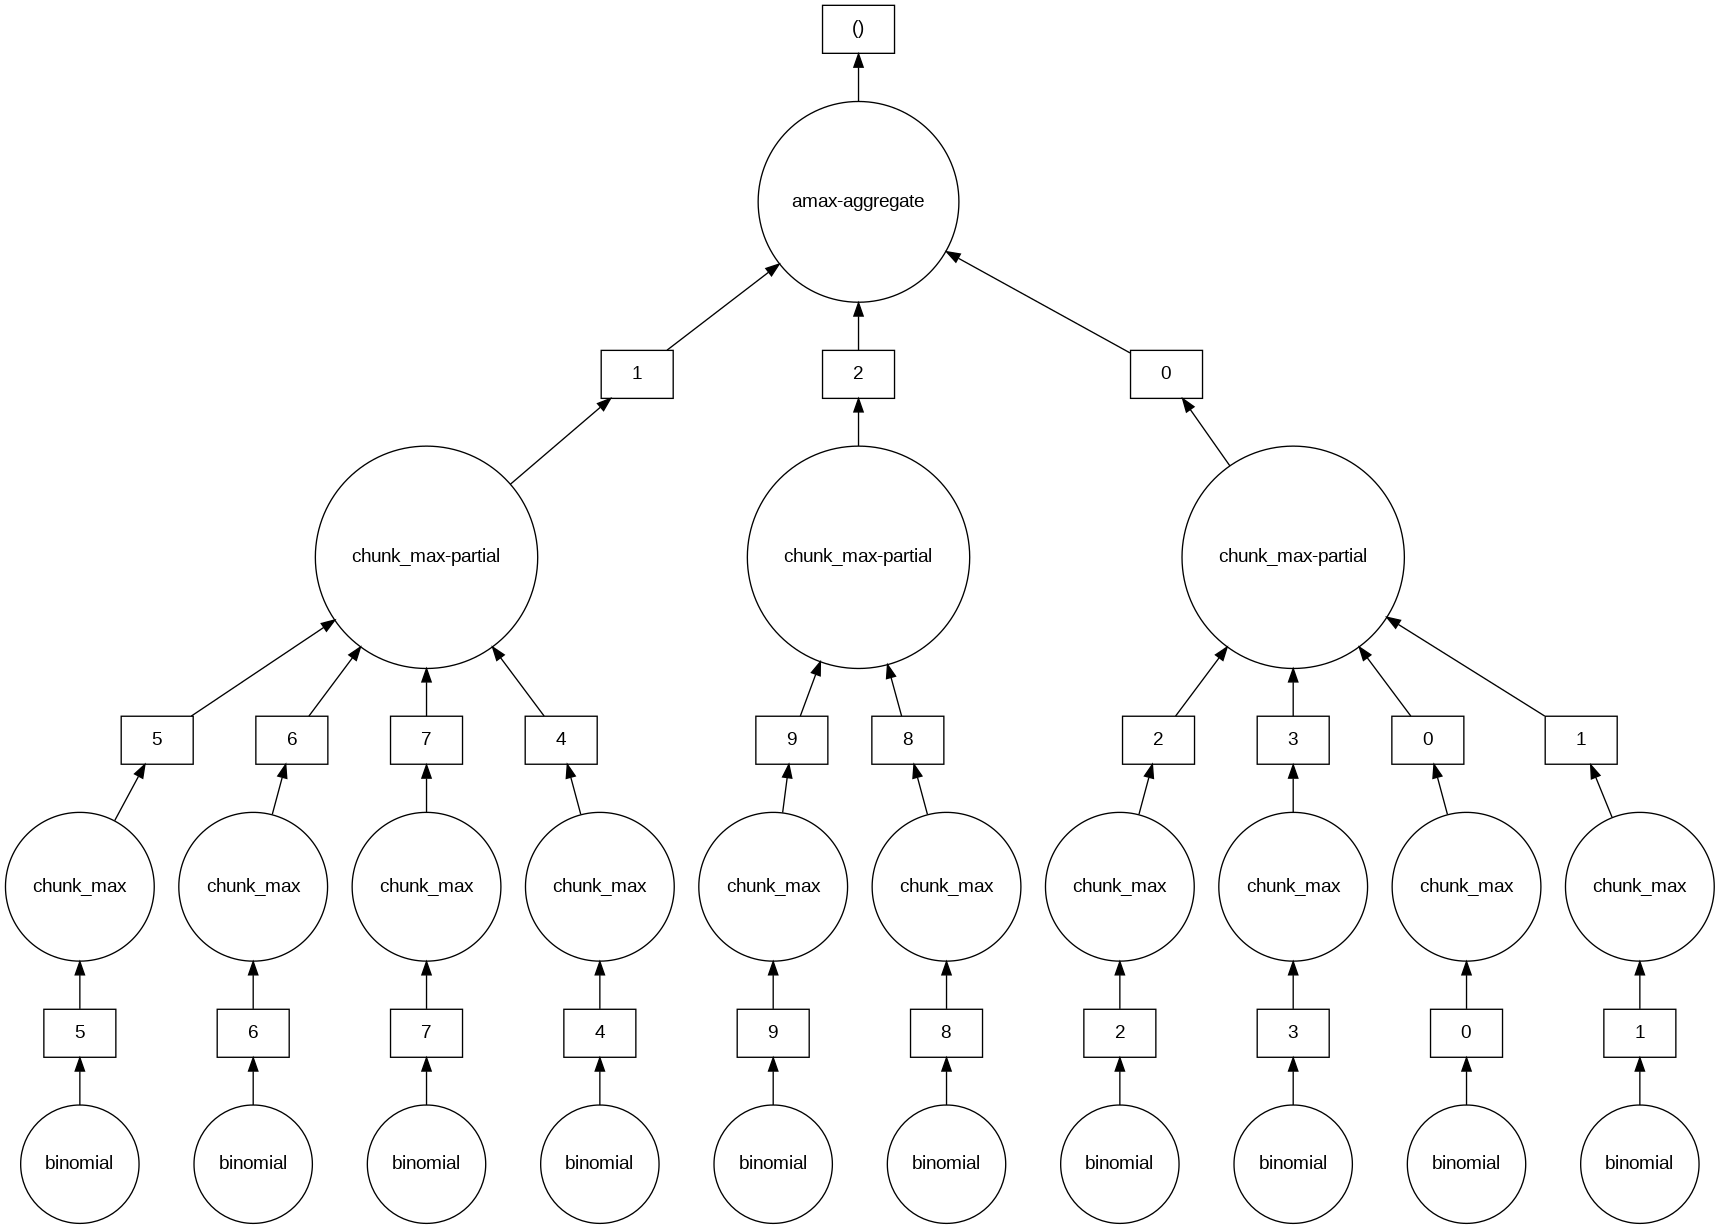

In [ ]:
# before computing, you can visualize the execution plan. If everything is ok, so you can call compute()
da.max().visualize()

In [ ]:
da.max().compute()

46

# CSV

In [ ]:
df = dataframe.read_csv('/content/mvt_cleaned.csv')
df.head()

,Date,Latitude,Longitude,DateTime,Hour,DayOfWeek
0,2012-12-31,41.756284,-87.621645,2012-12-31 23:15:00,23,0
1,2012-12-31,41.898788,-87.661303,2012-12-31 22:00:00,22,0
2,2012-12-31,41.969186,-87.767670,2012-12-31 22:00:00,22,0
3,2012-12-31,41.769329,-87.657726,2012-12-31 22:00:00,22,0
4,2012-12-31,41.837568,-87.621761,2012-12-31 21:30:00,21,0


In [ ]:
df_indexed = df.set_index('DateTime', sorted=True)

In [ ]:
df_indexed.divisions

('2001-01-01 00:01:00', '2012-12-31 23:15:00')

In [ ]:
# partitioning data by year

from datetime import datetime
from dask.dataframe.shuffle import set_partition

dates = [str(datetime(x, 1, 1)) for x in range(2001, 2013)]
df_partitioned = set_partition(df=df, index='DateTime', divisions=dates)
df_partitioned.divisions

('2001-01-01 00:00:00',
 '2002-01-01 00:00:00',
 '2003-01-01 00:00:00',
 '2004-01-01 00:00:00',
 '2005-01-01 00:00:00',
 '2006-01-01 00:00:00',
 '2007-01-01 00:00:00',
 '2008-01-01 00:00:00',
 '2009-01-01 00:00:00',
 '2010-01-01 00:00:00',
 '2011-01-01 00:00:00',
 '2012-01-01 00:00:00')

In [ ]:
df_partitioned.groupby('DayOfWeek').count().compute()

,Date,Latitude,Longitude,Hour
DayOfWeek,,,,
0,27397,27065,27065,27397
1,26791,26491,26491,26791
2,27416,27089,27089,27416
3,27319,26995,26995,27319
4,29284,28928,28928,29284
5,27118,26772,26772,27118
6,26316,26025,26025,26316


In [ ]:
df_partitioned.groupby('DayOfWeek').Hour.count().compute()

DayOfWeek
0    27397
1    26791
2    27416
3    27319
4    29284
5    27118
6    26316
Name: Hour, dtype: int64

In [ ]:
df_partitioned.Hour.value_counts().compute()

22    14745
0     13212
21    12434
20    11716
23    11293
18    10521
19    10427
17     8635
12     8158
9      8136
8      7866
16     7736
15     7512
7      6852
1      6643
10     6566
14     6419
13     5555
11     5415
2      5377
6      5136
3      4202
5      3728
4      3357
Name: Hour, dtype: int64

# Bags

Very useful to process unstructured data

In [ ]:
def is_even(n):
    return n % 2 == 0

b = bag.from_sequence([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# map: apply a function to each element
c = b.filter(is_even).map(lambda x: x ** 2)
c.compute()

[4, 16, 36, 64, 100]

In [ ]:
def count_occurrencies(d):
    return {'name': d['name'], 'count': len(d['transactions'])}

# map: apply a function to each element
# pluck: select a field, as from a dictionary, element[field]

(some_bag.filter(lambda record: record['name'] == 'Alice')
   .map(count_occurrencies)
   .pluck('count')
   .take(5))

In [ ]:
# reduction: Reduce collection with reduction operators.

b = bag.from_sequence([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
b.reduction(sum, sum).compute()

55

In [ ]:
# groupby: Shuffles data so that all items with the same key are in the same key-value pair
# groupby is slow. Try to use Bag.foldby

b = bag.from_sequence(['Alice', 'Bob', 'Charlie', 'Dan', 'Edith', 'Frank'])
b.groupby(len).compute()  # names grouped by length

[(7, ['Charlie']), (3, ['Bob', 'Dan']), (5, ['Alice', 'Edith', 'Frank'])]

In [ ]:
# foldby(key, binop, combine)
# A key function determines how to group the elements in your bag.
# Binop (binary operator) takes a running total and a new element and produces a new total. It continuosly add to a total.
# Combine takes two totals and combines them.
# https://docs.dask.org/en/stable/generated/dask.bag.Bag.foldby.html

b = bag.from_sequence([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
is_even = lambda x: x % 2
b.foldby(is_even, # key
         binop=max, # binop
         combine=max # combine
         ).compute()

[(1, 9), (0, 10)]

In [18]:
# Select item from all tuples/dicts in collection.

b = bag.from_sequence([{'name': 'Alice', 'credits': [1, 2, 3]},
                       {'name': 'Bob',   'credits': [10, 20]}])
print(list(b.pluck('name')))
print(list(b.pluck('name'))[0])


print(list(b.pluck('credits').pluck(0)))

['Alice', 'Bob']
Alice
[1, 10]


In [3]:
!wget https://data.gharchive.org/2016-01-01-{0..23}.json.gz

--2023-07-04 23:12:31--  https://data.gharchive.org/2016-01-01-0.json.gz
Resolving data.gharchive.org (data.gharchive.org)... 104.21.46.175, 172.67.168.206, 2606:4700:3037::6815:2eaf, ...
Connecting to data.gharchive.org (data.gharchive.org)|104.21.46.175|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4414816 (4.2M) [application/gzip]
Saving to: ‘2016-01-01-0.json.gz’

2016-01-01-0.json.g 100%[===================>]   4.21M  --.-KB/s    in 0.1s    

2023-07-04 23:12:32 (28.3 MB/s) - ‘2016-01-01-0.json.gz’ saved [4414816/4414816]

--2023-07-04 23:12:32--  https://data.gharchive.org/2016-01-01-1.json.gz
Reusing existing connection to data.gharchive.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 4010933 (3.8M) [application/gzip]
Saving to: ‘2016-01-01-1.json.gz’

2016-01-01-1.json.g 100%[===================>]   3.82M  --.-KB/s    in 0.02s   

2023-07-04 23:12:32 (157 MB/s) - ‘2016-01-01-1.json.gz’ saved [4010933/4010933]

--2023-07-04 23:12:32-- 

In [4]:
!wget https://data.gharchive.org/2015-12-31-{0..23}.json.gz

--2023-07-04 23:12:39--  https://data.gharchive.org/2015-12-31-0.json.gz
Resolving data.gharchive.org (data.gharchive.org)... 104.21.46.175, 172.67.168.206, 2606:4700:3037::6815:2eaf, ...
Connecting to data.gharchive.org (data.gharchive.org)|104.21.46.175|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7885556 (7.5M) [application/gzip]
Saving to: ‘2015-12-31-0.json.gz’

2015-12-31-0.json.g 100%[===================>]   7.52M  42.5MB/s    in 0.2s    

2023-07-04 23:12:40 (42.5 MB/s) - ‘2015-12-31-0.json.gz’ saved [7885556/7885556]

--2023-07-04 23:12:40--  https://data.gharchive.org/2015-12-31-1.json.gz
Reusing existing connection to data.gharchive.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 7186771 (6.9M) [application/gzip]
Saving to: ‘2015-12-31-1.json.gz’

2015-12-31-1.json.g 100%[===================>]   6.85M  --.-KB/s    in 0.1s    

2023-07-04 23:12:40 (50.4 MB/s) - ‘2015-12-31-1.json.gz’ saved [7186771/7186771]

--2023-07-04 23:12:40--

In [5]:
# content example

! zcat /content/2015-12-31-0.json.gz | head

{"id":"3484991453","type":"IssueCommentEvent","actor":{"id":16410501,"login":"MartinsZB","gravatar_id":"","url":"https://api.github.com/users/MartinsZB","avatar_url":"https://avatars.githubusercontent.com/u/16410501?"},"repo":{"id":25084719,"name":"MagoKimbra/MarlinKimbra","url":"https://api.github.com/repos/MagoKimbra/MarlinKimbra"},"payload":{"action":"created","issue":{"url":"https://api.github.com/repos/MagoKimbra/MarlinKimbra/issues/88","labels_url":"https://api.github.com/repos/MagoKimbra/MarlinKimbra/issues/88/labels{/name}","comments_url":"https://api.github.com/repos/MagoKimbra/MarlinKimbra/issues/88/comments","events_url":"https://api.github.com/repos/MagoKimbra/MarlinKimbra/issues/88/events","html_url":"https://github.com/MagoKimbra/MarlinKimbra/issues/88","id":124407605,"number":88,"title":"M105 response","user":{"login":"MartinsZB","id":16410501,"avatar_url":"https://avatars.githubusercontent.com/u/16410501?v=3","gravatar_id":"","url":"https://api.github.com/users/MartinsZ

In [6]:
from dask import bag
import json

In [7]:
db = bag.read_text(['/content/2015*.json.gz', '/content/2016*.json.gz']).map(json.loads)
db

dask.bag<loads, npartitions=48>

In [8]:
db.count().compute()

859983

In [9]:
# Bag.take(k, npartitions=1, compute=True, warn=True)[source]
# k: The number of elements to return
# npartitions: Elements are only taken from the first npartitions, with a default of 1.

first = db.take(1)[0]
first

{'id': '3484991453',
 'type': 'IssueCommentEvent',
 'actor': {'id': 16410501,
  'login': 'MartinsZB',
  'gravatar_id': '',
  'url': 'https://api.github.com/users/MartinsZB',
  'avatar_url': 'https://avatars.githubusercontent.com/u/16410501?'},
 'repo': {'id': 25084719,
  'name': 'MagoKimbra/MarlinKimbra',
  'url': 'https://api.github.com/repos/MagoKimbra/MarlinKimbra'},
 'payload': {'action': 'created',
  'issue': {'url': 'https://api.github.com/repos/MagoKimbra/MarlinKimbra/issues/88',
   'labels_url': 'https://api.github.com/repos/MagoKimbra/MarlinKimbra/issues/88/labels{/name}',
   'comments_url': 'https://api.github.com/repos/MagoKimbra/MarlinKimbra/issues/88/comments',
   'events_url': 'https://api.github.com/repos/MagoKimbra/MarlinKimbra/issues/88/events',
   'html_url': 'https://github.com/MagoKimbra/MarlinKimbra/issues/88',
   'id': 124407605,
   'number': 88,
   'title': 'M105 response',
   'user': {'login': 'MartinsZB',
    'id': 16410501,
    'avatar_url': 'https://avatars.g

In [22]:
db.map(lambda x: x['type']).frequencies(sort=True).compute()

[('PushEvent', 472118),
 ('CreateEvent', 102296),
 ('WatchEvent', 84809),
 ('IssueCommentEvent', 60842),
 ('PullRequestEvent', 36867),
 ('IssuesEvent', 34760),
 ('ForkEvent', 26823),
 ('DeleteEvent', 15690),
 ('PullRequestReviewCommentEvent', 9219),
 ('GollumEvent', 6048),
 ('CommitCommentEvent', 3703),
 ('ReleaseEvent', 3383),
 ('MemberEvent', 2767),
 ('PublicEvent', 658)]

In [20]:
# another way
db.pluck('type').frequencies().compute() # column value_counts

[('IssueCommentEvent', 60842),
 ('PullRequestEvent', 36867),
 ('CreateEvent', 102296),
 ('PushEvent', 472118),
 ('WatchEvent', 84809),
 ('IssuesEvent', 34760),
 ('DeleteEvent', 15690),
 ('ForkEvent', 26823),
 ('GollumEvent', 6048),
 ('ReleaseEvent', 3383),
 ('PullRequestReviewCommentEvent', 9219),
 ('MemberEvent', 2767),
 ('CommitCommentEvent', 3703),
 ('PublicEvent', 658)]

In [23]:
# filter and export results to files
db.filter(lambda x: 'PublicEvent' in x['type']).map(json.dumps).to_textfiles('outputs/*.json')

['/content/outputs/00.json',
 '/content/outputs/01.json',
 '/content/outputs/02.json',
 '/content/outputs/03.json',
 '/content/outputs/04.json',
 '/content/outputs/05.json',
 '/content/outputs/06.json',
 '/content/outputs/07.json',
 '/content/outputs/08.json',
 '/content/outputs/09.json',
 '/content/outputs/10.json',
 '/content/outputs/11.json',
 '/content/outputs/12.json',
 '/content/outputs/13.json',
 '/content/outputs/14.json',
 '/content/outputs/15.json',
 '/content/outputs/16.json',
 '/content/outputs/17.json',
 '/content/outputs/18.json',
 '/content/outputs/19.json',
 '/content/outputs/20.json',
 '/content/outputs/21.json',
 '/content/outputs/22.json',
 '/content/outputs/23.json',
 '/content/outputs/24.json',
 '/content/outputs/25.json',
 '/content/outputs/26.json',
 '/content/outputs/27.json',
 '/content/outputs/28.json',
 '/content/outputs/29.json',
 '/content/outputs/30.json',
 '/content/outputs/31.json',
 '/content/outputs/32.json',
 '/content/outputs/33.json',
 '/content/out

In [ ]:
import re
time_pattern = re.compile('[\d\-]+T(?P<hour>[\d]+)')
pushes_events = db.filter(lambda x: x['type'] == 'PushEvent')
hours = db.pluck('created_at').map(lambda x: re.search(time_pattern, x).group('hour'))
top_10 = hours.frequencies().topk(10, key=lambda time, count: count)
top_10.compute()

[('16', 42957),
 ('15', 42779),
 ('17', 42246),
 ('14', 40431),
 ('18', 39423),
 ('19', 39331),
 ('13', 37889),
 ('20', 37324),
 ('21', 36428),
 ('22', 35984)]

In [ ]:
def get_hours(row):
  return re.search(time_pattern, row['created_by']).group('hour')

def binop(total, row):
  '''Count  the total commits events'''
  return total + len(row['payload']['commits'])

def combine(total1, total2):
  '''Combine commits counts'''
  return total1 + total2

commits_events = db.foldby(get_hours, binop, initial=0, combine=combine) #Combined reduction and groupby. It walks through the data accumulating a result per key

top_10 = hours.frequencies().topk(10, key=lambda time, count: count)
top_10.compute()

[('16', 42957),
 ('15', 42779),
 ('17', 42246),
 ('14', 40431),
 ('18', 39423),
 ('19', 39331),
 ('13', 37889),
 ('20', 37324),
 ('21', 36428),
 ('22', 35984)]